# extract point data from gridded model fields

This notebook ...


# configure environment

In [1]:
work_dir       = './'
data_dir       = work_dir + 'DeepMIP-Eocene/User_Model_Database_v1.0/'

In [142]:
# load packages
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from netCDF4 import Dataset

# dictionary containing DeepMIP model names and experiments
from deepmipDict import deepmipDict
from pathlib import Path
from matplotlib import pyplot

# set figure resolution
#mpl.rcParams['figure.dpi']= 300 

# user input

In [3]:
variable  = "tas"
modernLat = -42.17
modernLon = -145.33

## step 1: find paleoposition for DeepMIP model geography

In [4]:
# open Herold et al. (2014) rotation file
rotationFile = xr.open_dataset(work_dir + 'LatLon_PD_55Ma_Herold2014.nc') 
# look up modern coordinates in rotation file
paleoLat     = rotationFile.LAT.sel(latitude=modernLat, longitude=modernLon, method='nearest').values
paleoLon     = rotationFile.LON.sel(latitude=modernLat, longitude=modernLon, method='nearest').values

In [5]:
print('modern location: LAT: ' + str(modernLat) + ' / LON: ' + str(modernLon) )
print('paleo location: LAT: ' + str(paleoLat) + ' / LON: ' + str(paleoLon) )

modern location: LAT: -42.17 / LON: -145.33
paleo location: LAT: -55.45 / LON: -105.65


## step 2: load model data at paleoposition

In [194]:
# allocate empty list to store results for all models
siteDataList = []

expts = ['piControl', 'deepmip_sens_1xCO2', 'deepmip_sens_2xCO2', 'deepmip_stand_3xCO2', 'deepmip_sens_4xCO2', 'deepmip_stand_6xCO2', 'deepmip_sens_9xCO2']
exptLabels = ['piControl', 'DeepMIP_1x', 'DeepMIP_2x', 'DeepMIP_3x', 'DeepMIP_4x', 'DeepMIP_6x', 'DeepMIP_9x']

# loop over all models and experiments
for modelCount, model in enumerate(deepmipDict.keys()):
    for expCount, exp in enumerate(expts):
        
        # construct filename following the DeepMIP convention
        modelFile = data_dir + deepmipDict[model]['group'] + '/' + model + '/' + exp + '/' + deepmipDict[model]['versn'] + \
                    '/' + model + '-' + exp + '-' + variable + '-' + deepmipDict[model]['versn'] + '.mean.nc'
        
        # load data if file for model/experiment combination exists
        if Path(modelFile).exists():
            modelDataset = xr.open_dataset(modelFile, decode_times=False)
            
            # get coordinate names
            for coord in modelDataset.coords:
                if coord in ['lat', 'latitude']:
                    latName = coord
                elif coord in ['lon', 'longitude']:
                    lonName = coord
                    
            if exp == 'piControl':
                lookupLat = modernLat
                lookupLon = modernLon
            else:
                lookupLat = paleoLat
                lookupLon = paleoLon              

            # check for [-180:180] or [0:360] longitudes
            minLon = np.amin(modelDataset.coords[lonName].values)
            if minLon >= 0.0:
                lookupLon = lookupLon + 180.0           

            siteData = modelDataset.tas.sel(**{latName: lookupLat}, **{lonName: lookupLon}, method='nearest').values - 273.15

            # store results for individual metrics in a list of dictionaries
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData), metric = 'annual mean' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.min(siteData), metric = 'monthly min' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.max(siteData), metric = 'monthly max' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[11,0,1]]), metric = 'DJF' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[2,3,4]]), metric = 'MAM' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[5,6,7]]), metric = 'JJA' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[8,9,10]]), metric = 'SON' ))

# convert dictionaries to Pandas dataframe after the loops for easier plotting  
df = pd.DataFrame(siteDataList)


## step 3: plot results

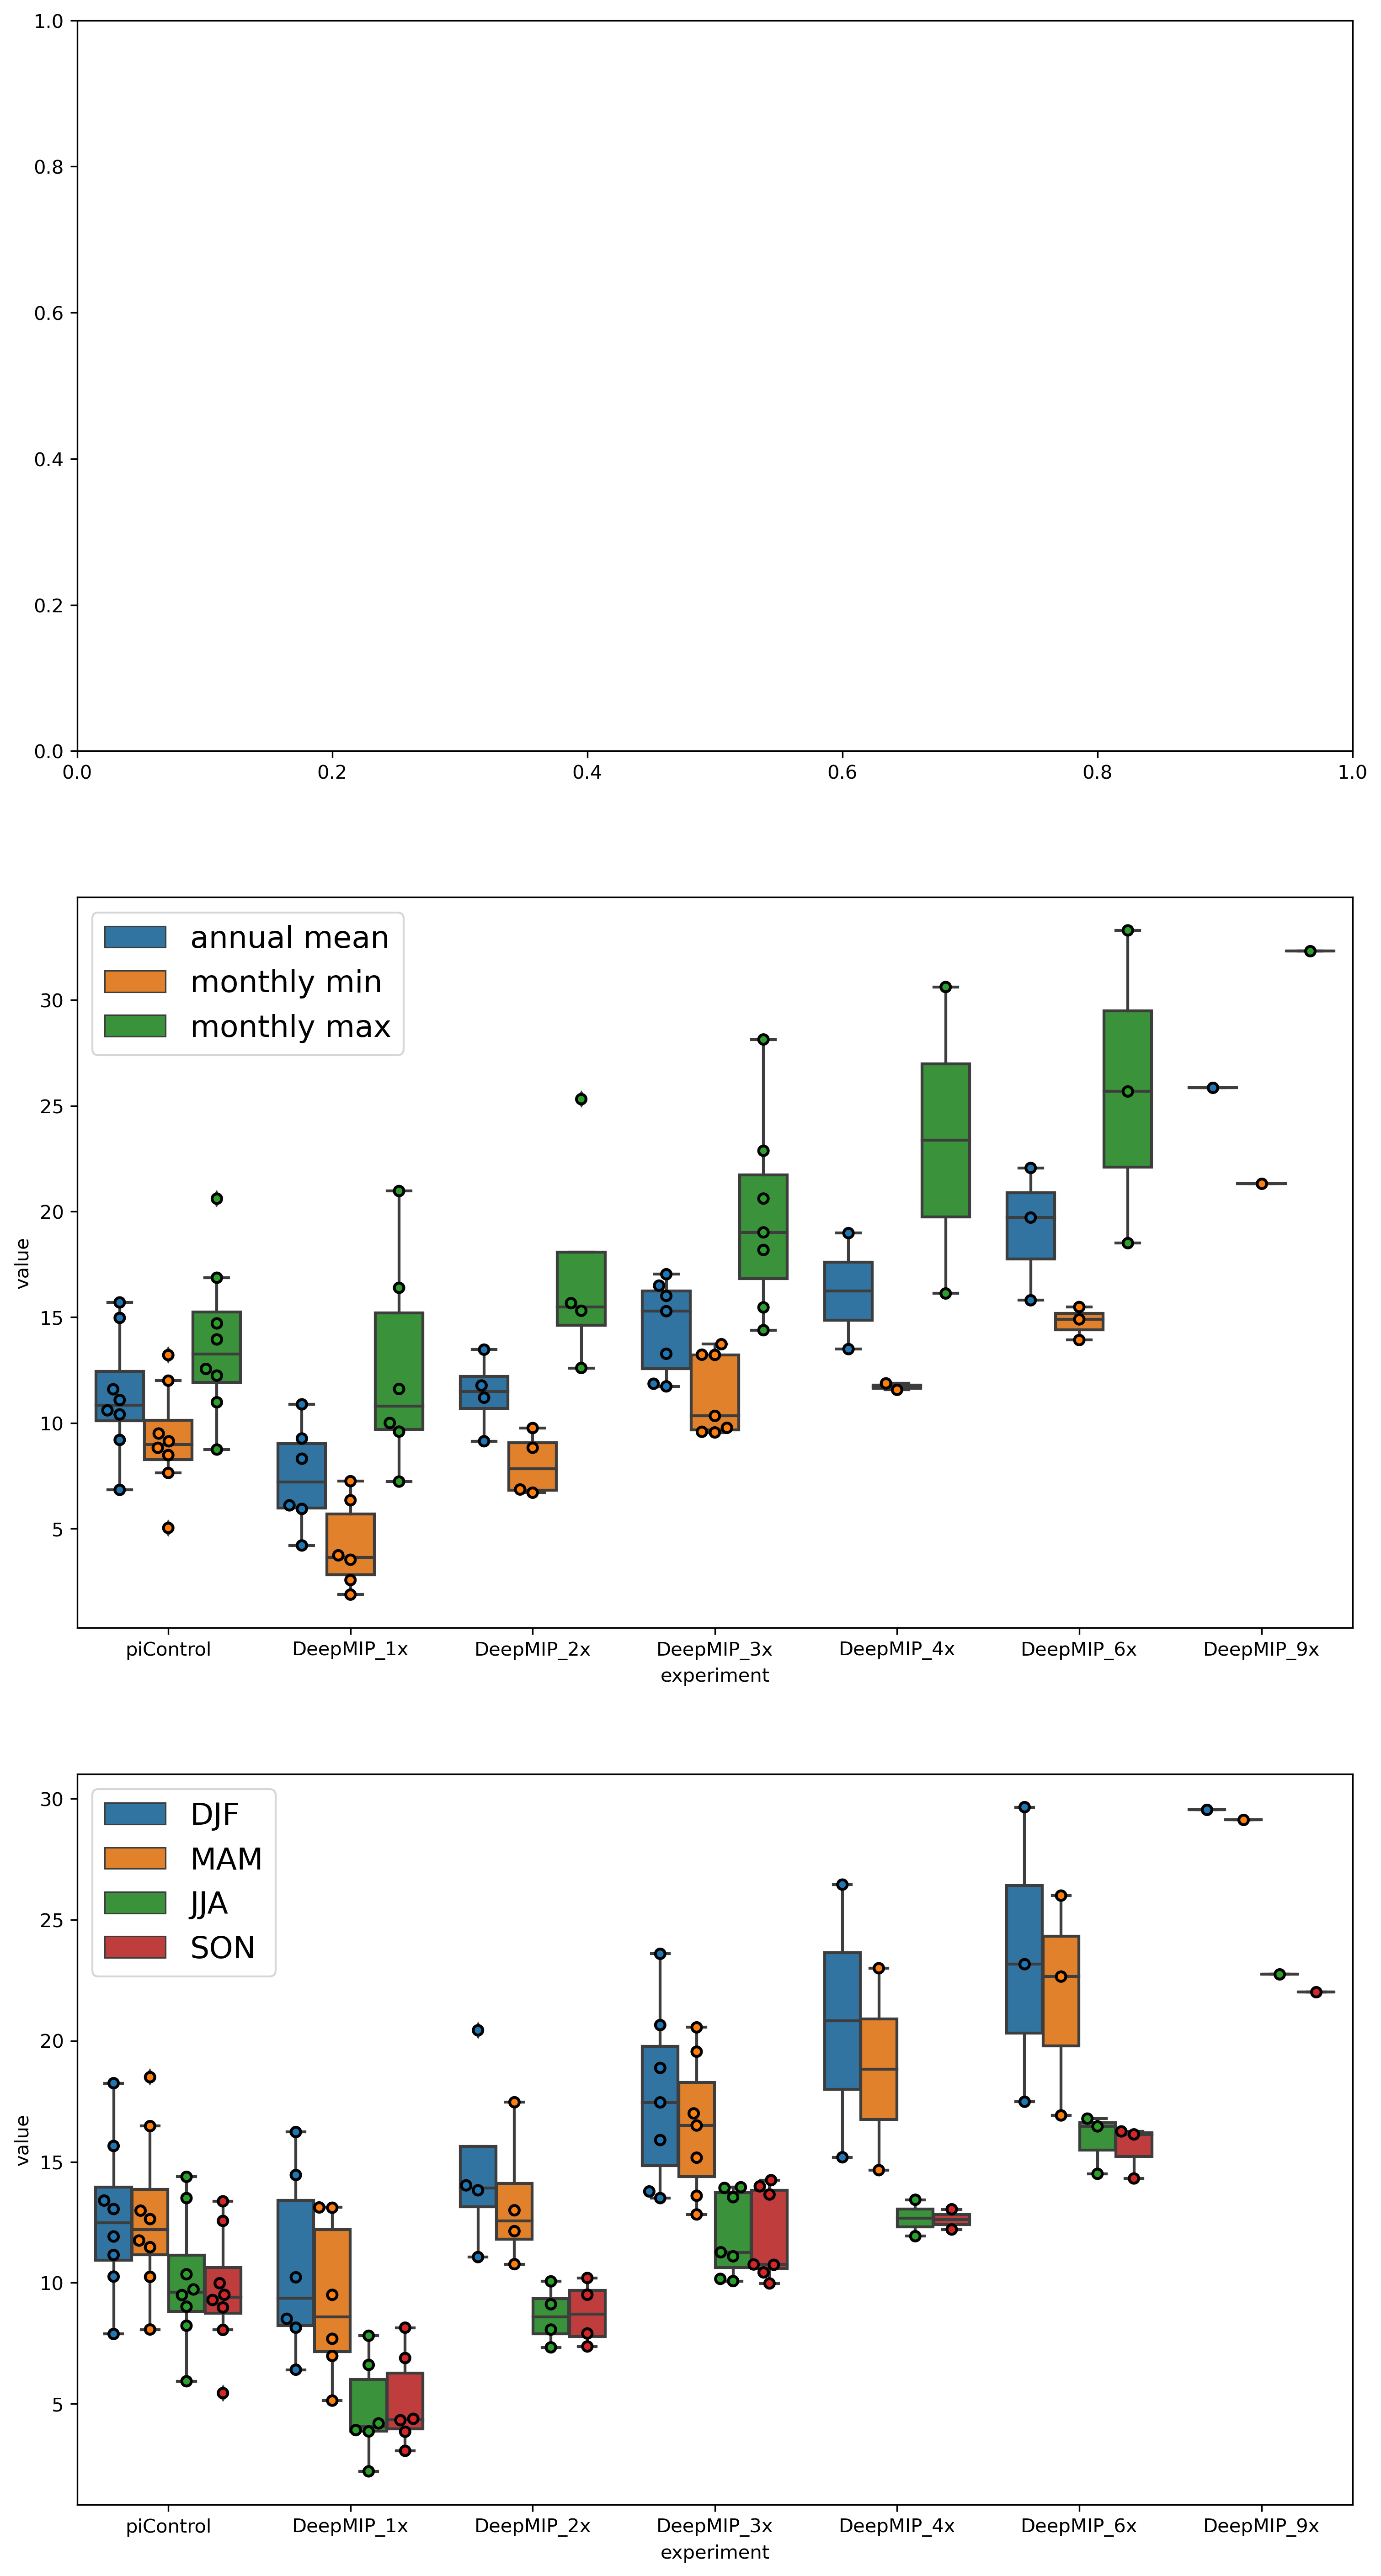

In [199]:
# define figure layout first
fig, axes = pyplot.subplots(3, 1, figsize=(12, 24))

# paleogeography with site marker


# boxplot with seaborn (https://seaborn.pydata.org/generated/seaborn.boxplot.html)
ax1 = sns.boxplot(data=df, x="experiment", y="value", hue='metric', hue_order=['annual mean', 'monthly min', 'monthly max'], order=exptLabels, ax=axes[1])
ax1 = sns.swarmplot(data=df, x="experiment", y="value", hue='metric', hue_order=['annual mean', 'monthly min', 'monthly max'], order=exptLabels, linewidth=1.5, edgecolor='black', size=5, dodge=True, ax=axes[1])

ax2 = sns.boxplot(data=df, x="experiment", y="value", hue='metric', hue_order=['DJF', 'MAM', 'JJA', 'SON'], order=exptLabels, ax=axes[2])
ax2 = sns.swarmplot(data=df, x="experiment", y="value", hue='metric', hue_order=['DJF', 'MAM', 'JJA', 'SON'], order=exptLabels, linewidth=1.5, edgecolor='black', size=5, dodge=True, ax=axes[2])

# modify legends
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[0:3], labels[0:3], fontsize='16')

handles2, labels2 = axes[2].get_legend_handles_labels()
ax2.legend(handles2[0:4], labels2[0:4], fontsize='16')


In [115]:
df  

,model,experiment,value,metric
0,CESM1.2_CAM5,piControl,11.590932,annual mean
1,CESM1.2_CAM5,piControl,9.498291,monthly min
2,CESM1.2_CAM5,piControl,13.948639,monthly max
3,CESM1.2_CAM5,deepmip_sens_1xCO2,10.878827,annual mean
4,CESM1.2_CAM5,deepmip_sens_1xCO2,7.245117,monthly min
...,...,...,...,...
615,MIROC4m,deepmip_stand_3xCO2,15.464417,monthly max
616,MIROC4m,deepmip_stand_3xCO2,13.774811,DJF
617,MIROC4m,deepmip_stand_3xCO2,13.595612,MAM
618,MIROC4m,deepmip_stand_3xCO2,10.071340,JJA
